# XGBoost to predict discharge disability: Comparing four models to predict whether patient dies, or not.

### Plain English summary

Training and comparing four different XGBoost models to predict whether a patient dies, or not.

1) binary model (dead, not dead) using threshold 0.5. Fit this model in this notebook.
2) binary model (dead, not dead) using threshold of specificity-sensitivity intersection. Use model as fitted for #1.
3) multi-class classification model (use the mRS6 classification outcome) using threshold 0.5. [model from notebook 040]
4) multi-class classification model (use the mRS6 classification outcome) using threshold of specificity-sensitivity intersection. [model from notebook 040]

### Model and data

Use two models (one trained in this notebook, one from notebook 040):

1) Binary XGBoost model\

Model: XGBoost classifier (binary classification) [trained in this notebook]\
Target feature: Patient mRS6 on discharge (dead)\
Input features: 7 features (prior_disability, stroke_severity, stroke_team, age, onset_to_thrombolysis_time, any_afib_diagnosis, precise_onset_known)\
Kfold split: First kfold split\


2) Multiclass XGBoost model\

Model: XGBoost classifier (multiclass classification) [from notebook 040]\
Target feature: Discharge disability\
Input features: 7 features (prior_disability, stroke_severity, stroke_team, age, onset_to_thrombolysis_time, any_afib_diagnosis, precise_onset_known)\
Kfold split: First kfold split\

Test performance of each model using threshold for classification:
1) 0.5
2) specificity-sensitivity intersection

### Aims

### Observations




#### Further work

#### Resources
Was "230726_xgb_all_data_death_binary_vs_multiclass_accuracy_EDITS_TT.ipynb"

## Import libraries

In [472]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

from dataclasses import dataclass

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix

from matplotlib.lines import Line2D

import pickle

from os.path import exists

from sklearn.metrics import accuracy_score

import time
import datetime

Report the time duration to run notebook

In [473]:
start_time = time.time()

Choose the kfold to use

In [474]:
k = 0

Select the features for the model

In [475]:
selected_features = ["prior_disability", "stroke_severity", "stroke_team", 
                     "age", "onset_to_thrombolysis_time", "any_afib_diagnosis", 
                     "precise_onset_known"]
n_features = len(selected_features)

## Set up paths and filenames

In [476]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_save_path: str = './saved_data'
    data_read_path: str = '../data_processing/output/kfold_5fold'
    model_text: str = f'xgb_7_features_1fold_death'
    notebook: str = '070_'

paths = Paths()

Create output folders if needed

In [477]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

## Import data

First kfold data

In [478]:
# Read in training set
filename = os.path.join(paths.data_read_path, 
                        ('03_train_' + str(k) + '.csv'))
train = pd.read_csv(filename)

filename = os.path.join(paths.data_read_path, 
                        ('03_test_' + str(k) + '.csv'))
test = pd.read_csv(filename)

Create and calculate the target feature for the binary model: Dead or not dead

In [479]:
def create_mrs6_target_feature(data):
    """ 
    Add a column to the dataframe ("discharge_mrs6") which is a binary feature 
    for whether the patient is dead on discharge

    Args:
        data [dataframe]: Row per patient, column per feature

    Return:
        data [dataframe]: As above, with new feature returned

    """
    data["discharge_mrs6"] = 0
    mask = data["discharge_disability"] == 6
    data["discharge_mrs6"][mask] = 1
    
    return(data)

In [480]:
train = create_mrs6_target_feature(train)
test = create_mrs6_target_feature(test)

Extract input features (same for the two models)

In [481]:
X_train = train[selected_features]
X_test = test[selected_features]

Extract two target features (one for binary model, one for multiclass model)

In [482]:
y_train_mc = train['discharge_disability']
y_test_mc = test['discharge_disability']
y_train_bin = train['discharge_mrs6']
y_test_bin = test['discharge_mrs6']

Check the balance of classes for the binary target feature

In [483]:
train_proportion_die = y_train_bin.value_counts()[1]/y_train_bin.shape[0]
test_proportion_die = y_test_bin.value_counts()[1]/y_test_bin.shape[0]
print(f'Percent of patients recorded dead on discharge: {round(train_proportion_die,2)*100}%')
print(f'Percent of patients recorded dead on discharge: {round(test_proportion_die,2)*100}%')

Percent of patients recorded dead on discharge: 12.0%
Percent of patients recorded dead on discharge: 12.0%


In [484]:
print(f"A model that classifies all as alive (0% sensitivity, 100% specificity) will have an accuracy in the training set of {100 - (round(train_proportion_die,2)*100)}%. We hope that a model can improve on this.")
print(f"A model that classifies all as alive (0% sensitivity, 100% specificity) will have an accuracy in the test set of {100 - (round(test_proportion_die,2)*100)}%. We hope that a model can improve on this.")

A model that classifies all as alive (0% sensitivity, 100% specificity) will have an accuracy in the training set of 88.0%. We hope that a model can improve on this.
A model that classifies all as alive (0% sensitivity, 100% specificity) will have an accuracy in the test set of 88.0%. We hope that a model can improve on this.


One hot the categorical feature (stroke team).

Define a function

In [485]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    Converts a categorical feature into a one hot encoded feature
    
    Args:
        df [dataframe]: training or test dataset
        feature_name [str]: feature to convert to one hot encoding
        prefix [str]: string to use on new feature

    Return:
        df [dataframe]: One hot encoded representation of the feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Convert the feature "stroke_team" to one hot encoded

In [486]:
X_train = convert_feature_to_one_hot(X_train, "stroke_team", "team")
X_test = convert_feature_to_one_hot(X_test, "stroke_team", "team")

Get list of features in dataset, post one hot encoding.

In [487]:
feature_names_ohe = list(X_train)
n_features = len(feature_names_ohe)

In [488]:
print(f"There are {len(selected_features)} original features "
      f"(before one-hot encoding)")
print(f"There are {n_features} features (after one-hot encoding)")

There are 7 original features (before one-hot encoding)
There are 124 features (after one-hot encoding)


Function to calculate some accuracy measures (returns a dataframe)

In [489]:
def calculate_accuracy(observed, predicted):
    
    """
    Calculates three accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
     * sensitivity: Same as recall
     * specificity: Proportion of true -ve identified:        

    Args:
        observed [array]: actual outcome per patient
        predicted [array]: predicted outcome per patient from model
    
    Return:
        results [dictionary]: returns a dictionary with three key words (for 
                three accuracy measures: sensitivity, specificity, accuracy)
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)

    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    false_negatives = (predicted_negatives == 1) & (observed_negatives == 0)
       
    sensitivity = np.sum(true_positives) / np.sum(observed_positives)
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['accuracy'] = np.mean(predicted == observed)
    
    return results

Define function to fit model (or read it in if it exists)

In [490]:
def fit_xgboost(X_data, y_data, filename):
    """ 
    Fit xgboost model (or read it in if it exists)

    Args:
        X_data [dataframe]: contains input features
        y_data [dataframe]: contains target feature
        filename [string]: contains filename to save model (or model to read in)

    Return:
        model [xgboost classifier object]: trained model
    """
    
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
        # load model
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
    else:        

        # Define model
        model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5)

        # Fit model
        model.fit(X_data, y_data)

        # Save model
        with open(filename, 'wb') as filehandler:
            pickle.dump(model, filehandler)

    return(model)

Define function to calculate the prediction and probabilites from an xgboost model

In [491]:
def calculate_predicted_probabilities(model, X_data):
    """ 
    Given a model and input data, return the models probability and prediction
    for each instance.
    
    Args:
        model [xgboost classifier object]: trained model
        X_data [dataframe]: input features for model

    Return:
        y_probs [array]: the probability of being in each target feature class
        y_pred [array]: the prediction (the class with the largest probability)
    """
    y_probs = model.predict_proba(X_data)
    y_pred = model.predict(X_data)

    return(y_probs, y_pred)

Define function to plot confusion matrix (can be called to populate a subplot)

In [492]:
def plot_confusion_matrix(y_data, y_pred, xlabel, ylabel, title, vmax="",
                          ax="", shrink=1):
    
    """ 
    
    Args:
        y_data [dataframe]: observed for each instance
        y_pred [dataframe]: prediction for each instance
        xlabel [string]: set as x axis label
        ylabel [string]: set as y axis label
        title [string]: set as title
        vmax [float]: set as maximum
        ax [matplotlib axis object]: empty axis
    
    Return:
        ax [matplotlib axis object]: confusion matrix

    """

    # Show confusion matrix
    cm = confusion_matrix(y_data, y_pred)
    if vmax=="":
        vmax = cm.max()
    # Visualize the confusion matrix with colors

    if ax == "":
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(1,1,1)
    heatmap = plt.imshow(cm, cmap=plt.cm.Blues, origin='lower', vmax=vmax)
    plt.xticks((0,1))
    plt.yticks((0,1))
    plt.colorbar(heatmap, shrink=shrink, ax=ax, alpha=0.5, label='Count')

    # To add values to plot
    for i in range(len(cm)):
        for j in range(len(cm[0])):
            plt.text(j, i, cm[i][j], ha='center', va='center', color='r')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    return(ax)

Define function to calculate Receiver Operator Characteristic Curve

In [493]:
def calculate_auc(y_data, y_probs):
    """ 
    
    Args:
        y_data [dataframe]: observed for each instance
        y_probs [dataframe]: probability for each instance (for each class)

    Return:
        fpr []: false positive rate
        tpr []: true positive rate
        thresholds []: thresholds at which the false and true positives 
                       calculated for
        roc_auc []: Area under the Receiver operator curve

    """
    fpr, tpr, thresholds = roc_curve(y_data, y_probs)
    roc_auc = auc(fpr, tpr)
    return(fpr, tpr, thresholds, roc_auc)

Define function to calculate data for sensitivity-specificity curve

In [494]:
def calculate_sensitivity_specificity(y_data, y_probs):
    """ 
    
    Args:
        y_data [dataframe]: observed for each instance
        y_probs [dataframe]: probability for each instance (for each class)

    Return:
        sensitivity []:
        specificity []:
        thresholds []:

    """

    # Initiate empty lists
    sensitivity = []
    specificity = []

    # Loop through increments in probability of survival
    thresholds = np.arange(0.0, 1.01, 0.01)
    for cutoff in thresholds: #  loop 0 --> 1 on steps of 0.1
        # Get classificiation using cutoff
        predicted_class = y_probs >= cutoff
        predicted_class = predicted_class * 1.0
        # Call accuracy measures function
        accuracy = calculate_accuracy(y_data, predicted_class)
        # Add accuracy scores to lists
        sensitivity.append(accuracy['sensitivity'])
        specificity.append(accuracy['specificity'])

    return(sensitivity, specificity, thresholds)

Define function to create a combined plot: ROC and sensitivity-specificity

In [495]:
def plot_roc_and_sen_spec(fpr, tpr, roc_auc, intersection, 
                          sensitivity, specificity, filename="", title=""):
    """ 

    Args:
        fpr []:
        tpr []:
        roc_auc []:
        sensitivity []:
        specificity []:
        filename []:

    Return:
        None
    
    """
    fig = plt.figure(figsize=(10,5))
    fig.suptitle(title)
    
    # Plot ROC
    ax1 = fig.add_subplot(121)
    ax1.plot(fpr, tpr, color='orange')
    ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operator Characteristic Curve' +
                  f'\nAUC: {roc_auc:.3f}')
    plt.grid(True)

    # Plot sensitivity-specificity
    ax2 = fig.add_subplot(122)
    ax2.plot(sensitivity, specificity)
    ax2.set_xlabel('Sensitivity')
    ax2.set_ylabel('Specificity')
    ax2.set_title(f'Sensitivity-Specificity Curve' +
                  f'\nIntersection: {intersection:.3f}')
    plt.grid(True)


    plt.tight_layout(pad=2)

    if len(filename) > 0 :
        plt.savefig(filename, dpi=300)

    plt.show()

    return()

Define function to identify cross-over point on sensitivity-specificity curve\
Adjusting the classification threshold allows us to balance sensitivity (the proportion of patients receiving thrombolysis correctly identified) and specificity (the proportion of patients not receiving thrombolysis correctly identified). An increase in sensitivity causes a loss in specificity (and vice versa). Here we identify the pint where specificity and sensitivity hold the same value.

In [496]:
def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and 
    b2,b1.
    
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

Define function to identify the intersection points with line x=y

(use it to quantify the tradeoff between sensitivity and specificity)

In [497]:
def create_intersect_parameters(sensitivity, specificity):
    """ 
    
    Args:
        sensitivity []:
        specificity []:
    
    Return:
        a1 []:
        a2 []:
        b1 []:
        b2 []:
        
    """
    df = pd.DataFrame()
    df['sensitivity'] = np.array(sensitivity)
    df['specificity'] = np.array(specificity)
    df['spec greater sens'] = df['specificity'] > df['sensitivity']

    # find last index for senitivity being greater than specificity 
    mask = df['spec greater sens'] == False
    last_id_sens_greater_spec = np.max(df[mask].index)
    locs = [last_id_sens_greater_spec, last_id_sens_greater_spec + 1]
    points = df.iloc[locs][['sensitivity', 'specificity']]

    # Get intersetction with line of x=y
    a1 = list(points.iloc[0].values)
    a2 = list(points.iloc[1].values)
    b1 = [0, 0]
    b2 = [1, 1]

    return(a1, a2, b1, b2)

Define function to calculate calibration

In [498]:
def calculate_reliability_results(observed, probability):
    
    """
    Calculates reliability from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dataframe of the results.

    Args:
        observed [array]: actual outcome per patient
        predicted [array]: predicted outcome per patient from model
    
    Return:
        reliability_summary [dataframe]: 
    
    """

    # Bin data with numpy digitize (this will assign a bin to each case)
    step = 0.10
    bins = np.arange(step, 1+step, step)
    digitized = np.digitize(probability, bins)
        
    # Put results in DataFrame
    reliability = pd.DataFrame()
    reliability['bin'] = digitized
    reliability['probability'] = probability
    reliability['observed'] = observed
    classification = 1 * (probability > 0.5 )
    reliability['correct'] = observed == classification
    reliability['count'] = 1

    # Summarise data by bin in new dataframe
    reliability_summary = pd.DataFrame()

    # Add bins and k-fold to summary
    reliability_summary['bin'] = bins

    # Calculate mean of predicted probability of thrombolysis in each bin
    reliability_summary['confidence'] = \
        reliability.groupby('bin').mean()['probability']

    # Calculate the proportion of patients who receive thrombolysis
    reliability_summary['fraction_positive'] = \
        reliability.groupby('bin').mean()['observed']

    # Calculate proportion correct in each bin
    reliability_summary['fraction_correct'] = \
        reliability.groupby('bin').mean()['correct']

    # Calculate fraction of results in each bin
    reliability_summary['fraction_results'] = \
        reliability.groupby('bin').sum()['count'] / reliability.shape[0]
    
    return(reliability_summary)

Define function to plot calibration

In [499]:
def plot_callibration(reliability_summary, filename="", title=""):
    """ 
    
    Args:
        reliability_summary [dataframe]: 


    Return:
    """
    # Plot
    fig = plt.figure(figsize=(10,5))

    # Plot predicted prob vs fraction psotive
    ax1 = fig.add_subplot(1,1,1)

    # Loop through k-fold reliability results
    x = reliability_summary['confidence']
    y = reliability_summary['fraction_positive']
    ax1.plot(x,y, color='orange')
    # Add 1:1 line
    ax1.plot([0,1],[0,1], color='k', linestyle ='--')
    # Refine plot
    ax1.set_xlabel('Model probability')
    ax1.set_ylabel('Fraction positive')
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)

    ax1.grid()

    # instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()  
    x = reliability_summary['confidence']
    y = reliability_summary['fraction_results']
    ax2.plot(x,y, color='blue')
        
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 0.8)
    ax2.set_ylabel('Fraction of samples')

    custom_lines = [Line2D([0], [0], color='orange', alpha=0.6, lw=2),
                    Line2D([0], [0], color='blue', alpha = 0.6,lw=2)]

    ax1.grid()

    plt.title(title)
    plt.legend(custom_lines, ['Fraction positive', 'Fraction of samples'],
            loc='upper center')

    plt.tight_layout(pad=2)

    if len(filename) > 0:
        plt.savefig(filename, dpi=300)

    plt.show()
    return()

## Model 1: Predict death using binary target feature (use default threshold, 0.5)



Get xgboost model fitted to binary target feature.

In [500]:
filename = os.path.join(paths.model_save_path, 
                        (paths.notebook + paths.model_text + 
                         '_bin.p'))
model_bin = fit_xgboost(X_train, y_train_bin, filename)

Calculate the prediction and the probabilites 

In [501]:
(y_probs_bin, y_pred_bin) = calculate_predicted_probabilities(model_bin, X_test)

Show accuracy (identity)

In [502]:
accuracy_bin = calculate_accuracy(y_test_bin, y_pred_bin)
print (f'Accuracy (binary model): {accuracy_bin["accuracy"]:0.2f}')
print (f'Sensitivity (binary model): {accuracy_bin["sensitivity"]:0.2f}')
print (f'Specificity (binary model): {accuracy_bin["specificity"]:0.2f}')

Accuracy (binary model): 0.89
Sensitivity (binary model): 0.35
Specificity (binary model): 0.97


Plot confusion matrix for binary model

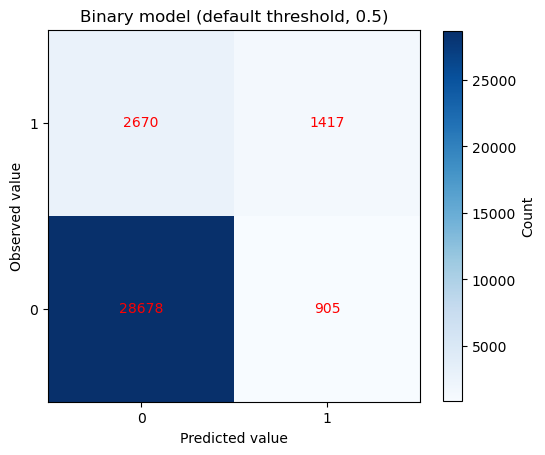

In [503]:
plot_confusion_matrix(y_test_bin, y_pred_bin, 
                      'Predicted value', 'Observed value', 
                      'Binary model (default threshold, 0.5)', shrink=0.8);

Calculate the accuracy of the binary model in terms of ROC AUC.

In [504]:
(fpr_bin, tpr_bin, thresholds_bin, roc_auc_bin) = (
                                calculate_auc(y_test_bin, y_probs_bin[:,1]))

Calculate data for sensitivity-specificity curve

In [505]:
(sensitivity_bin, specificity_bin, thresholds_bin) = (
            calculate_sensitivity_specificity(y_test_bin, y_probs_bin[:,1]))

Identify cross-over point on sensitivity-specificity curve\
Adjusting the classification threshold allows us to balance sensitivity (the proportion of patients receiving thrombolysis correctly identified) and specificity (the proportion of patients not receiving thrombolysis correctly identified). An increase in sensitivity causes a loss in specificity (and vice versa). Here we identify the pint where specificity and sensitivity hold the same value.

Identify the intersection points with line x=y (where is the tradeoff between sensitivity and specificity)

In [506]:
(a1, a2, b1, b2) = create_intersect_parameters(sensitivity_bin, specificity_bin)

intersection_bin = get_intersect(a1, a2, b1, b2)[0]

print (f'\nIntersection: {intersection_bin:0.4f}')


Intersection: 0.7888


Create a combined plot: ROC and sensitivity-specificity

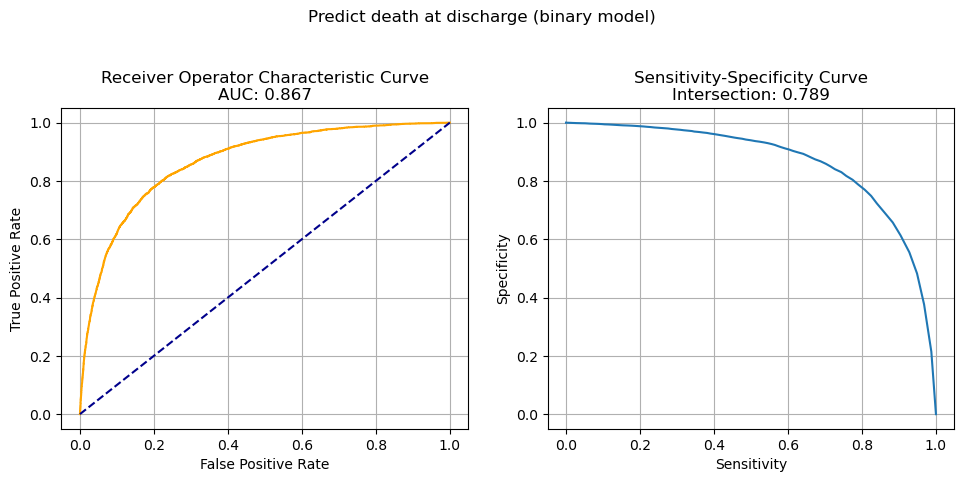

()

In [507]:
filename_bin = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                         '_bin_roc_sens_spec.jpg'))
                         
plot_roc_and_sen_spec(fpr_bin, tpr_bin, roc_auc_bin, intersection_bin,
                      sensitivity_bin, specificity_bin, filename=filename_bin,
                      title="Predict death at discharge (binary model)")

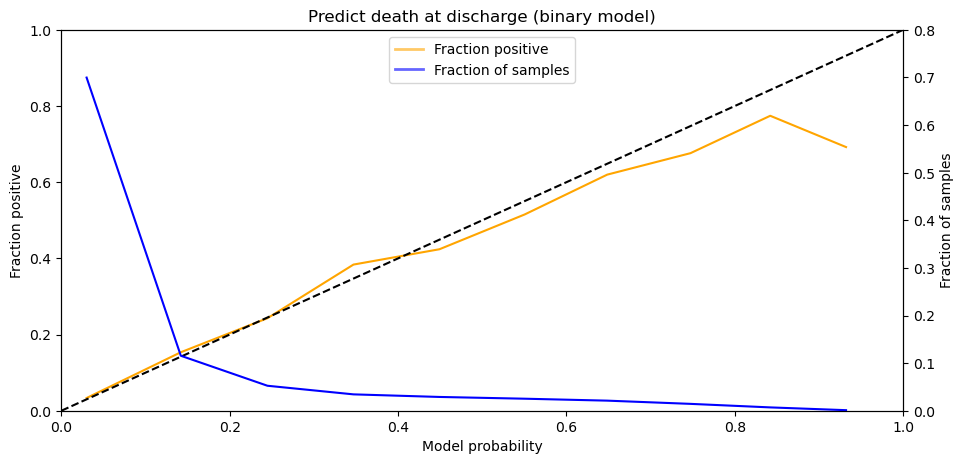

()

In [508]:
reliability_summary_bin = calculate_reliability_results(y_test_bin, 
                                                    y_probs_bin[:,1])

filename = os.path.join(paths.image_save_path, 
                       (paths.notebook + paths.model_text + 
                         '_reliability_bin.jpg'))

plot_callibration(reliability_summary_bin, filename=filename,
                  title="Predict death at discharge (binary model)")

## Model 2: Predict death using binary target feature (use threshold for sensitivity v. specificity intersection)

Use model as above.

Identify the threshold that gave this intersection.

In [509]:
threshold_intersection_bin = min(range(len(sensitivity_bin)), 
                             key=lambda i: abs(sensitivity_bin[i]-intersection_bin))

Confusion matrix with this threshold

In [510]:
y_pred_intersection_bin = (
    y_probs_bin[:,1] > thresholds_bin[threshold_intersection_bin])

accuracy_intersection_bin = calculate_accuracy(y_test_bin, 
                                               y_pred_intersection_bin)

print (f'Accuracy (binary model) [intersect threshold '
       f'{thresholds_bin[threshold_intersection_bin]:0.4f}]: '
       f'{accuracy_intersection_bin["accuracy"]:0.2f}')
print (f'Sensitivity (binary model) [intersect threshold '
       f'{thresholds_bin[threshold_intersection_bin]:0.4f}]: '
       f'{accuracy_intersection_bin["sensitivity"]:0.2f}')
print (f'Specificity (binary model) [intersect threshold '
       f'{thresholds_bin[threshold_intersection_bin]:0.4f}]: '
       f'{accuracy_intersection_bin["specificity"]:0.2f}')

Accuracy (binary model) [intersect threshold 0.1100]: 0.79
Sensitivity (binary model) [intersect threshold 0.1100]: 0.79
Specificity (binary model) [intersect threshold 0.1100]: 0.79


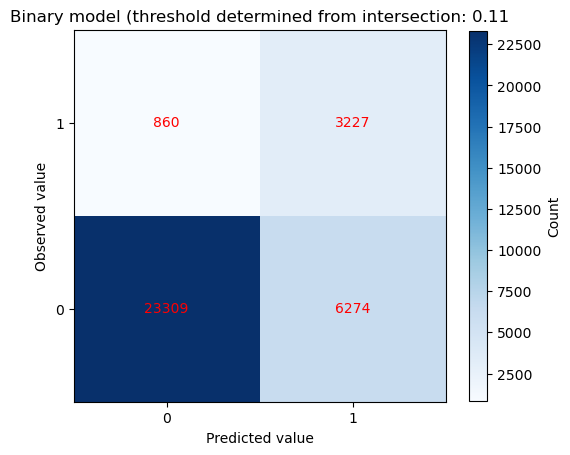

In [511]:
title = (f'Binary model (threshold determined from intersection: '
         f'{thresholds_bin[threshold_intersection_bin]:0.2f}')

plot_confusion_matrix(y_test_bin, y_pred_intersection_bin, 
                      'Predicted value', 'Observed value', 
                      title, shrink=0.8);

## Model 3: Predict death using multiclass target feature (use default threshold, 0.5)

#### Load XGBoost model from notebook 040

Create function to get xgboost model (print error if does not exist)

In [512]:
def load_xgboost_model(filename):
    """
    Given the filename, either load if the model exists (saved as a pickle), 
    else train a new model.

    Args:
        filename [string]: where xgboost model is saved
        
    Returns:
        model [object]: xgboost classifier model

    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
    else:
        # Print error
        print("Run notebook 040 first to train the model")
    return(model)

In [513]:
filename = os.path.join(paths.model_save_path, 
                ('040_xgb_7_features_5fold_0.p'))

model_mc = load_xgboost_model(filename)

In [514]:
(y_probs_mc, y_pred_mc) = calculate_predicted_probabilities(model_mc, X_test)

Get just the probability for death (outcome 6)

In [515]:
y_pred_mc6 = y_probs_mc[:,6] > 0.5

Calculate model accuracy

In [516]:
accuracy_mc = calculate_accuracy(y_test_bin, y_pred_mc6)
print (f'Accuracy ((multiclass) [default threshold]: {accuracy_mc["accuracy"]:0.2f}')
print (f'Sensitivity (multiclass) [default threshold]: {accuracy_mc["sensitivity"]:0.2f}')
print (f'Specificity (multiclass) [default threshold]: {accuracy_mc["specificity"]:0.2f}')

Accuracy ((multiclass) [default threshold]: 0.90
Sensitivity (multiclass) [default threshold]: 0.35
Specificity (multiclass) [default threshold]: 0.97


Confusion matrix

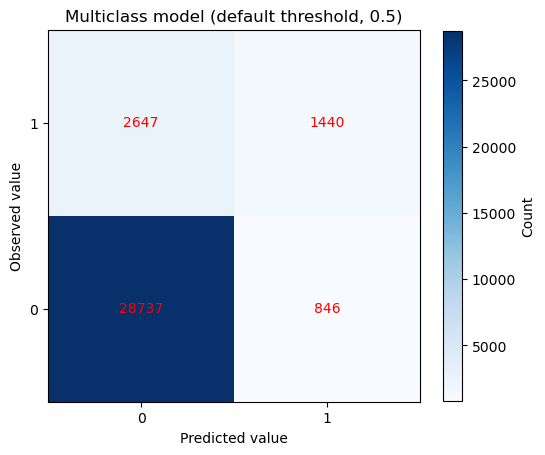

In [517]:
plot_confusion_matrix(y_test_bin, y_pred_mc6, 
                      'Predicted value', 'Observed value', 
                      'Multiclass model (default threshold, 0.5)', shrink=0.8);

Do the two different models (binary vs multiclass) predict the same outcome for each individual patient (when use default threshold, 0.5)?

Plot a confusion matrix

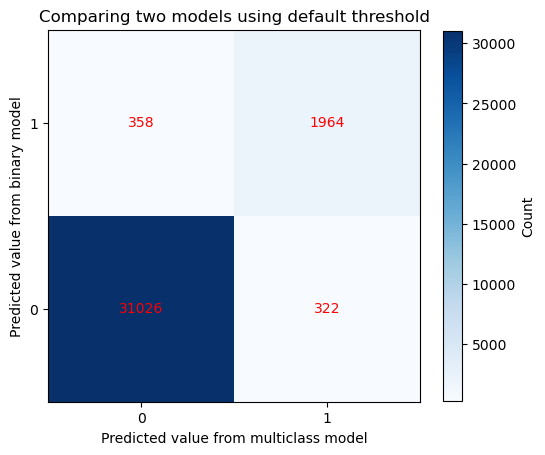

In [518]:
plot_confusion_matrix(y_pred_bin, y_pred_mc6, 
                      'Predicted value from multiclass model', 
                      'Predicted value from binary model', 
                      'Comparing two models using default threshold', 
                      shrink=0.8);

We don't know which of these patients are correctly classified.

Plot a confusion matrix of confusion matrices. For each individual confusion matrix limit the patients by whether they are classified correctly by the two models.

In [519]:
def cm_of_cms(y_pred_bin, y_pred_mc6, y_test_bin, suptitle):
    """
    y_pred_bin (array): classification of instances from the binary model
    y_pred_mc6 (array): classification of instances from the multiclass model 
                        (for death output only)
    y_test_bin (array): observed classification fo instances
    """
    
    # Categorise each patient by which of the two models correctly classified them
    # Give new label "category", where:
    # 10 only bin correct
    # 11 bin and mc correct
    # 01 only mc correct
    # 00 neither correct

    bin_correct = y_pred_bin == y_test_bin
    mc_correct = y_pred_mc6 == y_test_bin

    category = bin_correct * 10 + mc_correct

    fig = plt.figure(figsize = (12, 12))
    fig.suptitle(suptitle)
    for i in np.unique(category):
        mask = category == i
        binary_result = y_pred_bin[mask]
        mc_result = y_pred_mc6[mask]

        if i == 10:
            title = ('Patients that are only correctly classified by the binary ' 
                     + 'model')
            ax = plt.subplot(2, 2, 1)
        if i == 11:
            title = 'Patients that are correctly classified by both models)'
            ax = plt.subplot(2, 2, 2)
        if i == 0:
            title = 'Patients that are incorrectly classified by both models)'
            ax = plt.subplot(2, 2, 3)
        if i == 1:
            title = ('Patients that are only correctly classified by the '
                     + 'multiclass models')
            ax = plt.subplot(2, 2, 4)
        plot_confusion_matrix(binary_result, mc_result, 
                        'Predicted value from multiclass model',
                        'Predicted value from binary model',
                        title, ax=ax, vmax=27000, shrink=0.72)
    plt.tight_layout(pad=0)

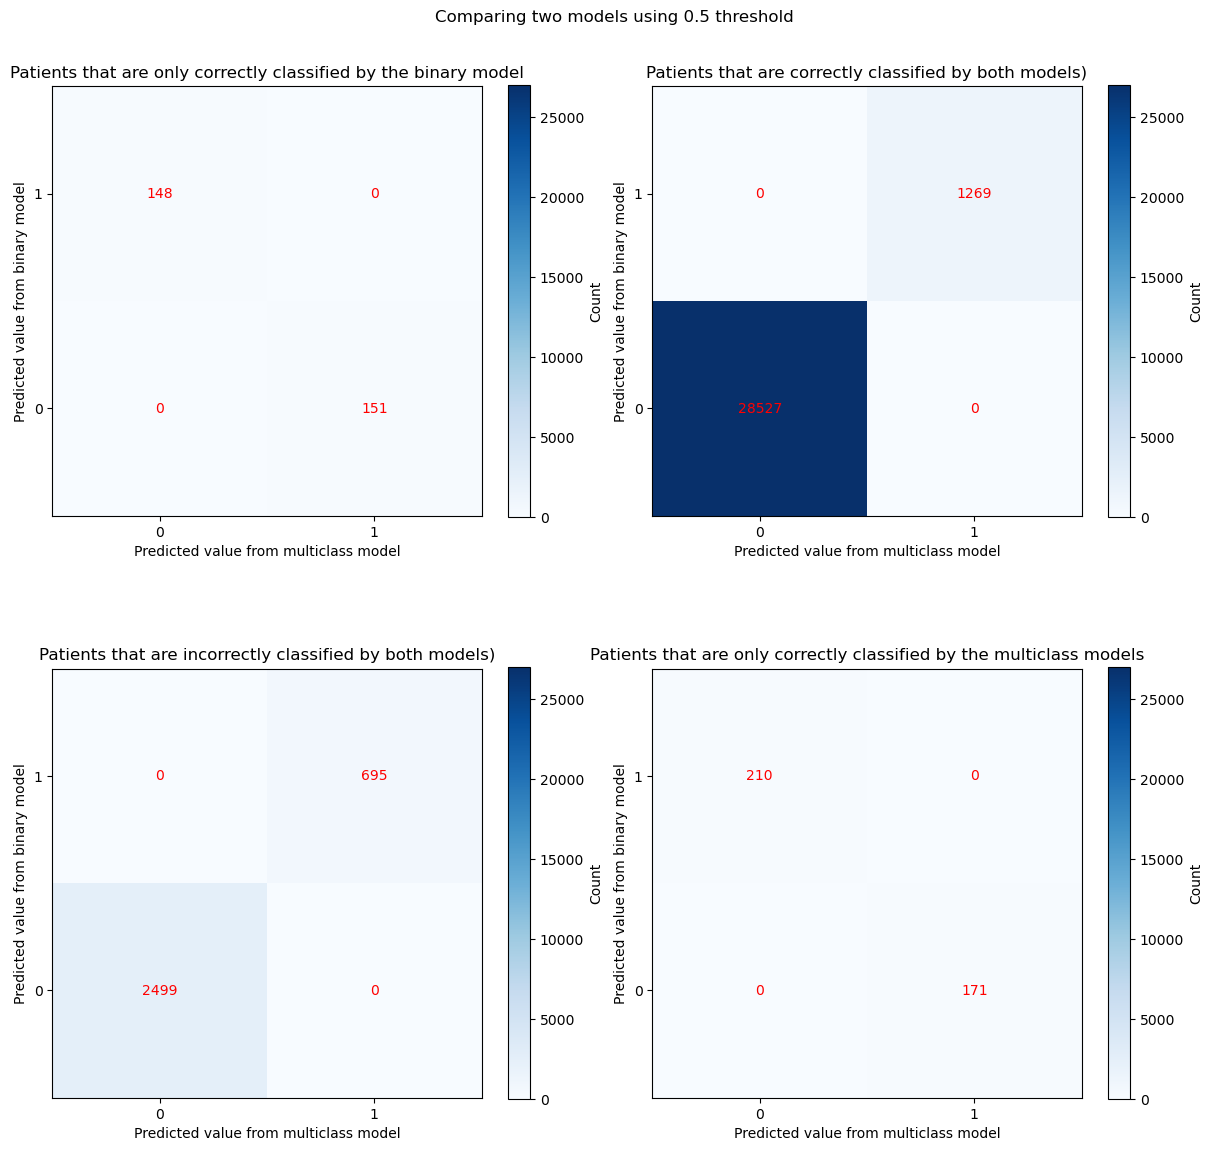

In [520]:
cm_of_cms(y_pred_bin, y_pred_mc6, y_test_bin, 
          "Comparing two models using 0.5 threshold")

Calculate ROC AUC

In [521]:
(fpr_mc, tpr_mc, thresholds_mc, roc_auc_mc) = (
                            calculate_auc(y_test_bin, y_probs_mc[:,6]))

Calculate sensitivity and specificity

In [522]:
(sensitivity_mc, specificity_mc, thresholds_mc) = (
                calculate_sensitivity_specificity(y_test_bin, y_probs_mc[:,6]))

Calculate intersection of sensitivity and specificity

In [523]:
(a1, a2, b1, b2) = create_intersect_parameters(sensitivity_mc, specificity_mc)

intersection_mc6 = get_intersect(a1, a2, b1, b2)[0]

Plot: 1) ROCAUC and 2) sensitivity and specificity

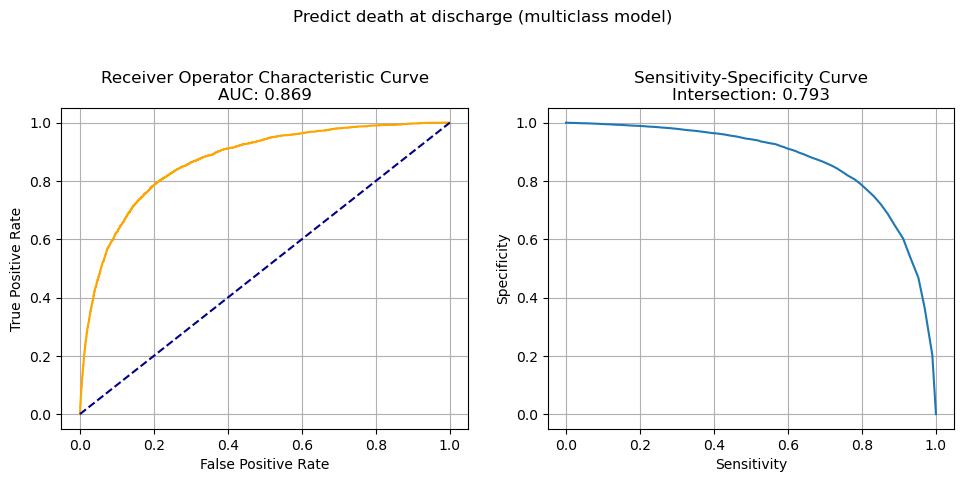

()

In [524]:
filename_mc = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                         '__mc_roc_sens_spec.jpg'))
plot_roc_and_sen_spec(fpr_mc, tpr_mc, roc_auc_mc, intersection_mc6,
                      sensitivity_mc, specificity_mc, filename=filename_mc,
                      title="Predict death at discharge (multiclass model)")

Calibration

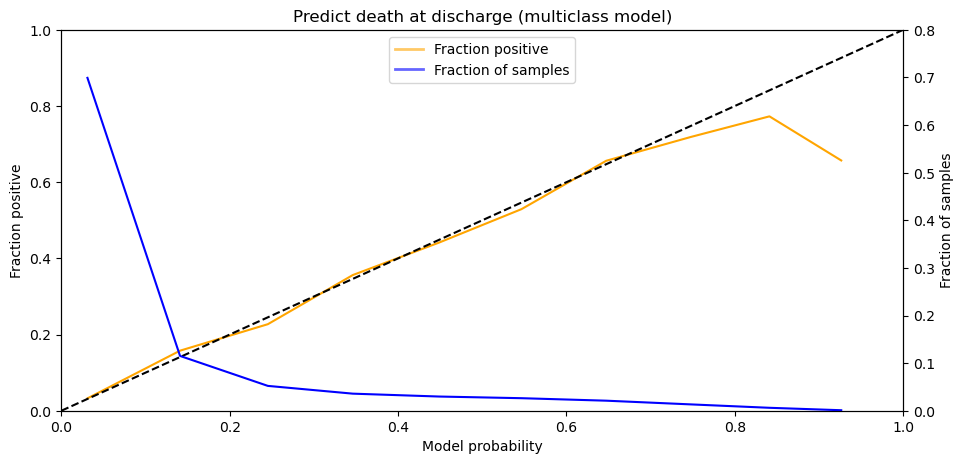

()

In [525]:
reliability_summary_mc6 = (
                calculate_reliability_results(y_test_bin, y_probs_mc[:,6]))

filename = os.path.join(paths.image_save_path, 
                       (paths.notebook + paths.model_text + 
                         '_reliability_mc.jpg'))

plot_callibration(reliability_summary_mc6, filename=filename,
                  title="Predict death at discharge (multiclass model)")

## Model 4: Predict death using multiclass target feature (use threshold for sensitivity v. specificity intersection)

Use model for first kfold from notebook 040

Find threshold to give this intersection

In [526]:
threshold_intersection_mc6 = (
            min(range(len(sensitivity_mc)), 
                key=lambda i: abs(sensitivity_mc[i]-intersection_mc6)))

In [527]:
y_pred_intersection_mc6 = (
                     y_probs_mc[:,6] > thresholds_mc[threshold_intersection_mc6])

accuracy_intersection_mc6 = calculate_accuracy(y_test_bin, 
                                               y_pred_intersection_mc6)
print (f'Accuracy (multiclass model) [intersect threshold ' + 
       f'{thresholds_mc[threshold_intersection_mc6]:0.2f}]: ' + 
       f'{accuracy_intersection_mc6["accuracy"]:0.2f}')
print (f'Sensitivity (multiclass model) [intersect threshold ' +
       f'{thresholds_mc[threshold_intersection_mc6]:0.2f}]: ' +
       f'{accuracy_intersection_mc6["sensitivity"]:0.2f}')
print (f'Specificity (multiclass model) [intersect threshold ' +
       f'{thresholds_mc[threshold_intersection_mc6]:0.2f}]: ' +
       f'{accuracy_intersection_mc6["specificity"]:0.2f}')

Accuracy (multiclass model) [intersect threshold 0.11]: 0.79
Sensitivity (multiclass model) [intersect threshold 0.11]: 0.80
Specificity (multiclass model) [intersect threshold 0.11]: 0.79


Confusion matrix with this threshold

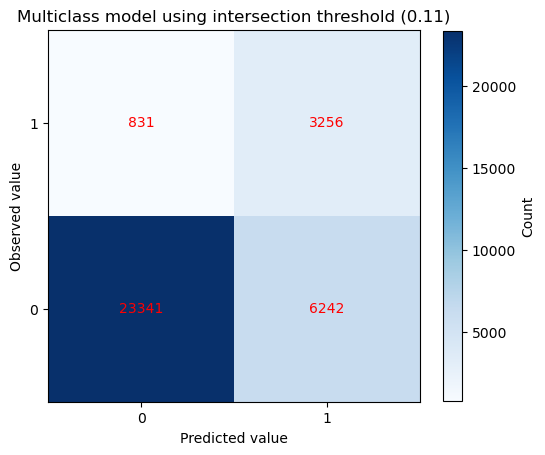

In [528]:
title = (f'Multiclass model using intersection threshold '+
         f'({thresholds_mc[threshold_intersection_mc6]:0.2f})')

plot_confusion_matrix(y_test_bin, y_pred_intersection_mc6, 
                      'Predicted value', 
                      'Observed value', 
                      title, shrink=0.8);

Do the two different models (binary vs multiclass) predict the same outcome for each individual patient (when use the threshold to give intersect for sensitivity and specificity)?

Plot a confusion matrix

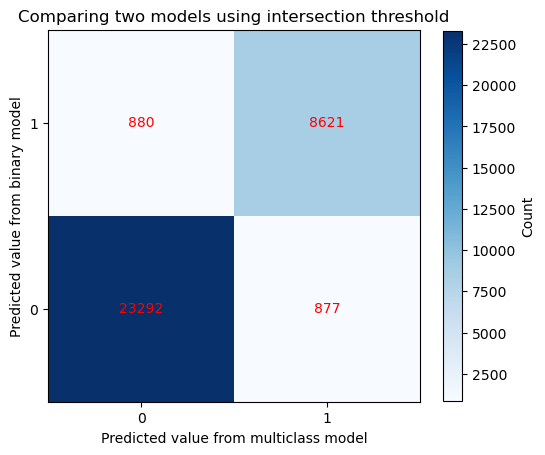

In [529]:
plot_confusion_matrix(y_pred_intersection_bin, y_pred_intersection_mc6, 
                      'Predicted value from multiclass model',
                      'Predicted value from binary model',
                      'Comparing two models using intersection threshold', 
                      shrink=0.8);

We don't know which of these patients are correctly classified.

Plot a confusion matrix of confusion matrices. For each individual confusion matrix limit the patients by whether they are classified correctly by the two models.

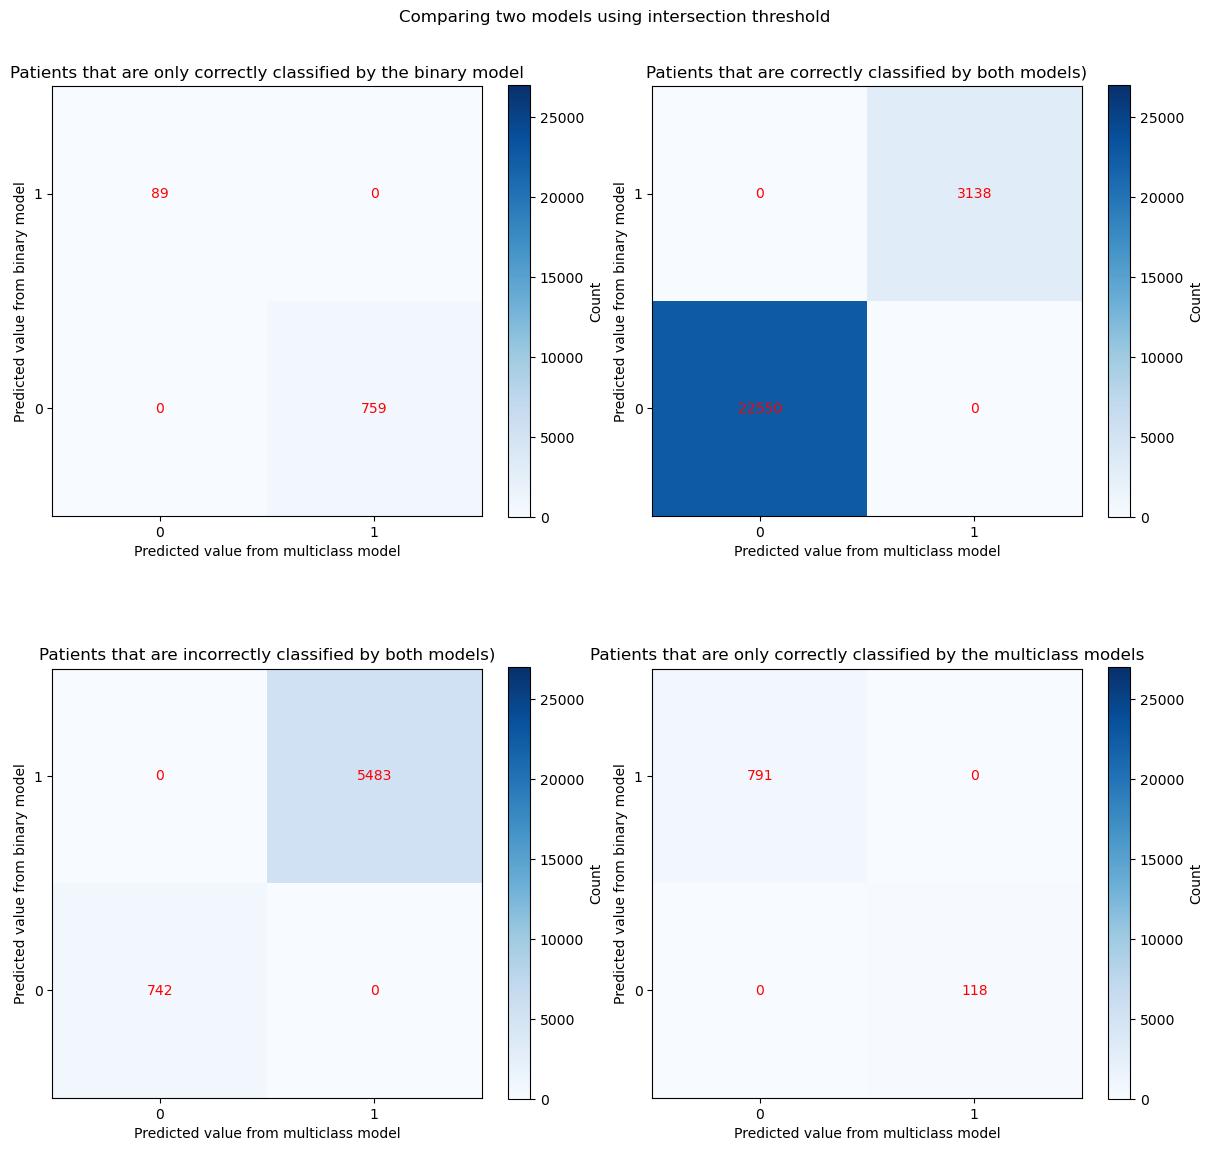

In [530]:
cm_of_cms(y_pred_intersection_bin, y_pred_intersection_mc6, y_test_bin, 
          "Comparing two models using intersection threshold")

## Summary section. Looking at the four performance confusion matrices together.

In [539]:
def create_accuracy_title(accuracy):
    title = (f'accuracy: {accuracy["accuracy"]:0.2f}, ' +
             f'sensitivity: {accuracy["sensitivity"]:0.2f}, ' +
             f'specificity: {accuracy["specificity"]:0.2f}')
    return(title)

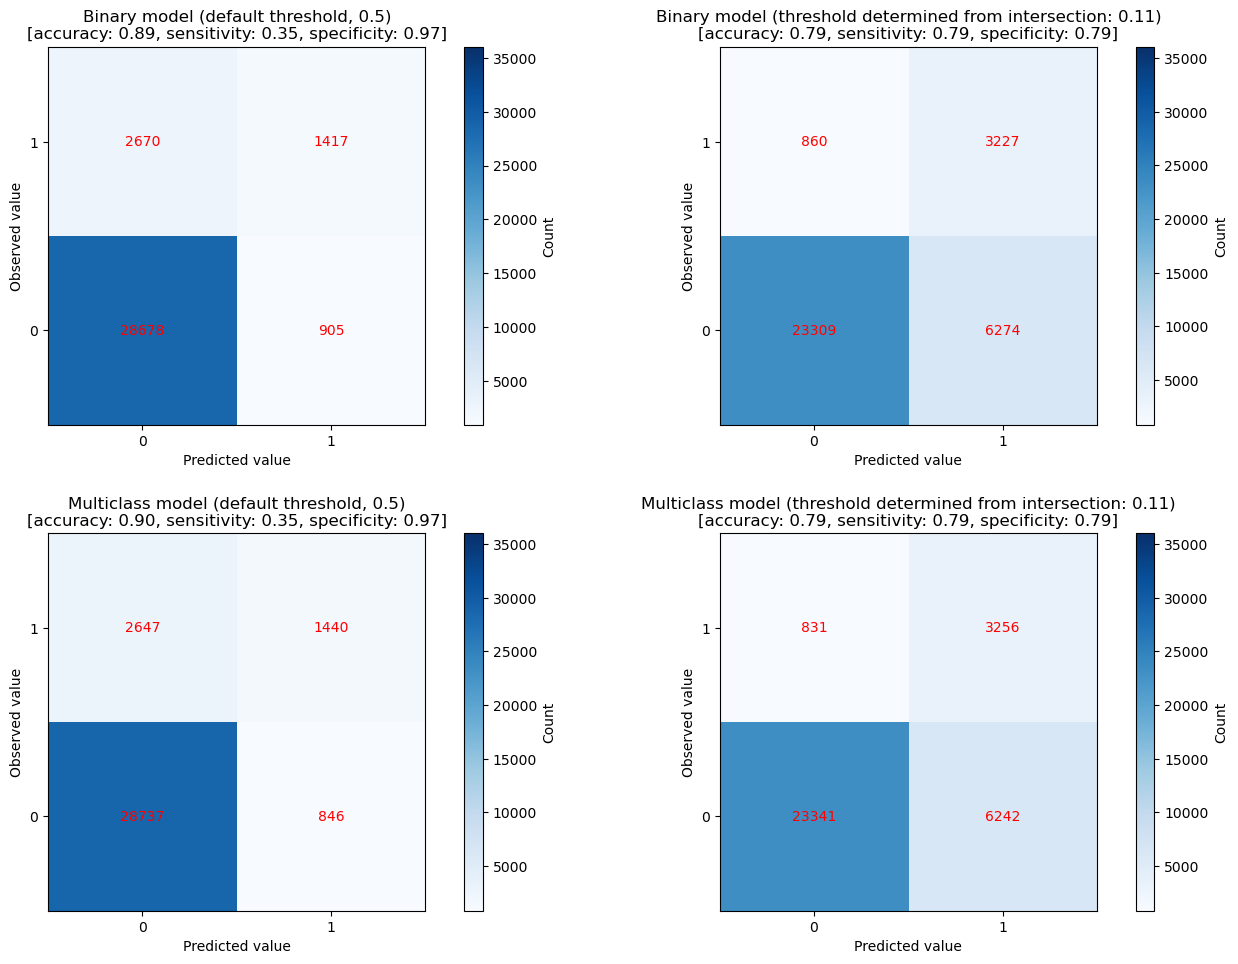

In [540]:
fig = plt.figure(figsize=(15, 10))
n_models = 4

perf_bin = create_accuracy_title(accuracy_bin)
perf_intersection_bin = create_accuracy_title(accuracy_intersection_bin)
perf_mc = create_accuracy_title(accuracy_mc)
perf_intersection_mc = create_accuracy_title(accuracy_intersection_mc6)
    
list_y_test = [y_test_bin, y_test_bin, y_test_bin, y_test_bin]
list_y_pred = [y_pred_bin, y_pred_intersection_bin, y_pred_mc6, 
               y_pred_intersection_mc6]
list_title = [f'Binary model (default threshold, 0.5)\n[{perf_bin}]',
              (f'Binary model (threshold determined from intersection: '
              f'{thresholds_bin[threshold_intersection_bin]:0.2f})\n'
              f'[{perf_intersection_bin}]'),
              f'Multiclass model (default threshold, 0.5)\n[{perf_mc}]',
              (f'Multiclass model (threshold determined from intersection: '
               f'{thresholds_mc[threshold_intersection_mc6]:0.2f})\n'
               f'[{perf_intersection_bin}]')]

for m in range(n_models):
    ax = fig.add_subplot(2,2,m+1)
    plot_confusion_matrix(list_y_test[m], list_y_pred[m], 
                         'Predicted value', 'Observed value', 
                         list_title[m], ax=ax, vmax=36000, shrink=1)

plt.subplots_adjust(bottom=0.25, wspace=0.05)

plt.tight_layout(pad=2)

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                         '_cm_for_4_models.jpg'))

plt.savefig(filename, dpi=300)
plt.show()

Plot ROC AUC for both models

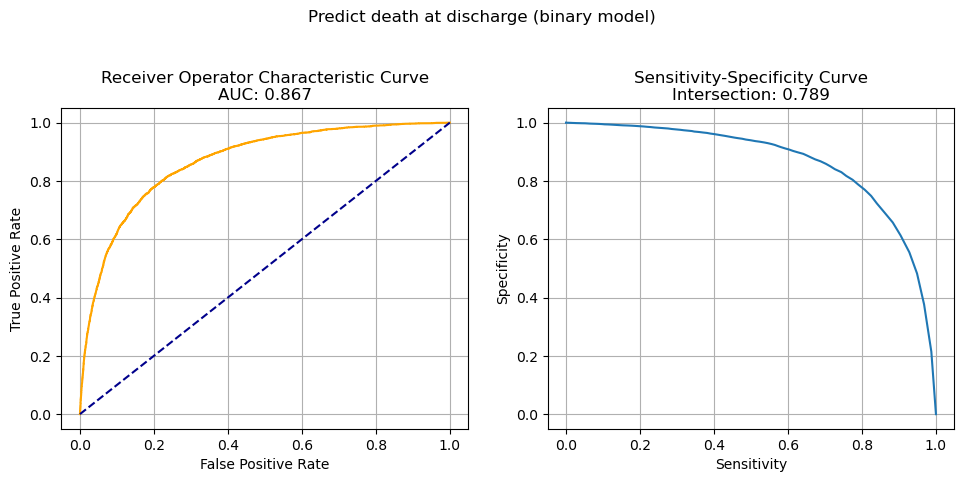

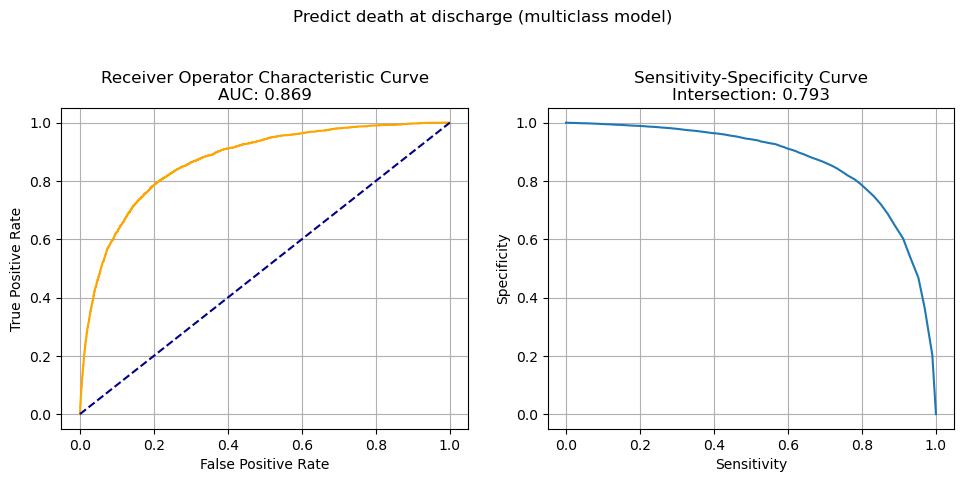

()

In [533]:
plot_roc_and_sen_spec(fpr_bin, tpr_bin, roc_auc_bin, intersection_bin,
                        sensitivity_bin, specificity_bin,
                        title="Predict death at discharge (binary model)")

plot_roc_and_sen_spec(fpr_mc, tpr_mc, roc_auc_mc, intersection_mc6,
                    sensitivity_mc, specificity_mc, 
                    title="Predict death at discharge (multiclass model)")

Plot reliability for both models

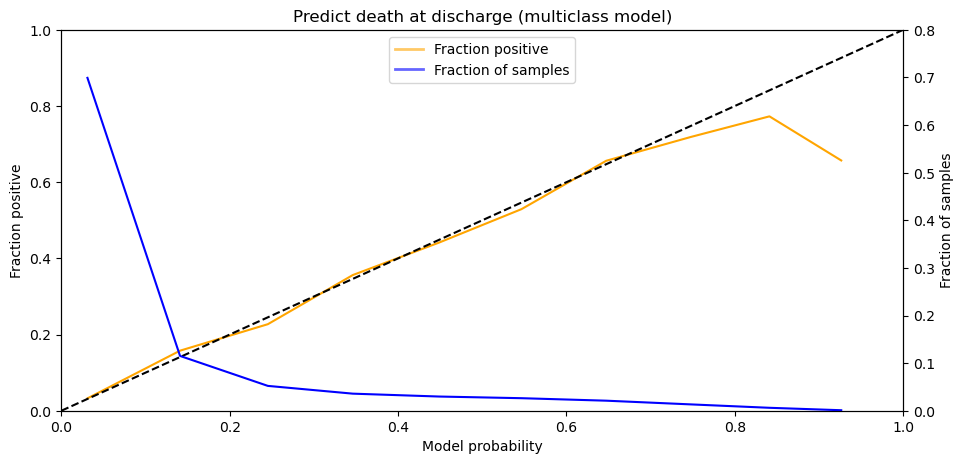

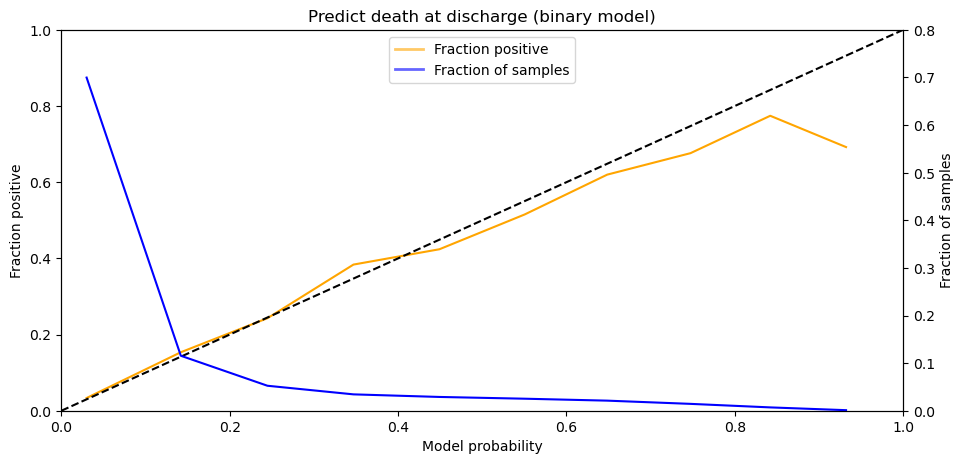

()

In [534]:
plot_callibration(reliability_summary_mc6, 
                  title="Predict death at discharge (multiclass model)")

plot_callibration(reliability_summary_bin, 
                  title="Predict death at discharge (binary model)")

Duration to run notebook

In [535]:
str(datetime.timedelta(seconds=(time.time()-start_time)))

'0:00:03.970910'